# Housing Price

In [56]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import autoreload
import missingno as msno
import warnings
import csv
import os
import sys

from collections import defaultdict, Counter

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

%matplotlib inline
plt.rcParams.update({'font.size':16})

sb.set_style('darkgrid')
sb.set()

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv(r"D:\Open Classroom\Datasets\Housing-New-Dataset\newhousing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,areaperbedroom,bbratio
0,5250000,5500,3,2,1,1,0,1,0,0,0,0,1,0,1833.333333,0.666667
1,4480000,4040,3,1,2,1,0,0,0,0,1,0,1,0,1346.666667,0.333333
2,3570000,3640,2,1,1,1,0,0,0,0,0,0,0,1,1820.000000,0.500000
3,2870000,3040,2,1,1,0,0,0,0,0,0,0,0,1,1520.000000,0.500000
4,3570000,4500,2,1,1,0,0,0,0,0,0,0,0,0,2250.000000,0.500000


In [61]:
df.shape

(545, 16)

In [63]:
df.isnull().sum()

price              0
area               0
bedrooms           0
bathrooms          0
stories            0
mainroad           0
guestroom          0
basement           0
hotwaterheating    0
airconditioning    0
parking            0
prefarea           0
semi-furnished     0
unfurnished        0
areaperbedroom     0
bbratio            0
dtype: int64

In [64]:
df['price'].dtypes

dtype('int64')

In [8]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
price,545.0,4766729.25,1870439.62,1750000.00,3430000.00,4340000.00,5740000.00,13300000.0
area,545.0,5150.54,2170.14,1650.00,3600.00,4600.00,6360.00,16200.0
bedrooms,545.0,2.97,0.74,1.00,2.00,3.00,3.00,6.0
bathrooms,545.0,1.29,0.50,1.00,1.00,1.00,2.00,4.0
stories,545.0,1.81,0.87,1.00,1.00,2.00,2.00,4.0
mainroad,545.0,0.86,0.35,0.00,1.00,1.00,1.00,1.0
guestroom,545.0,0.18,0.38,0.00,0.00,0.00,0.00,1.0
basement,545.0,0.35,0.48,0.00,0.00,0.00,1.00,1.0
hotwaterheating,545.0,0.05,0.21,0.00,0.00,0.00,0.00,1.0
airconditioning,545.0,0.32,0.47,0.00,0.00,0.00,1.00,1.0


Text(0.5, 1.0, 'Pearsons Correlation of Columns')

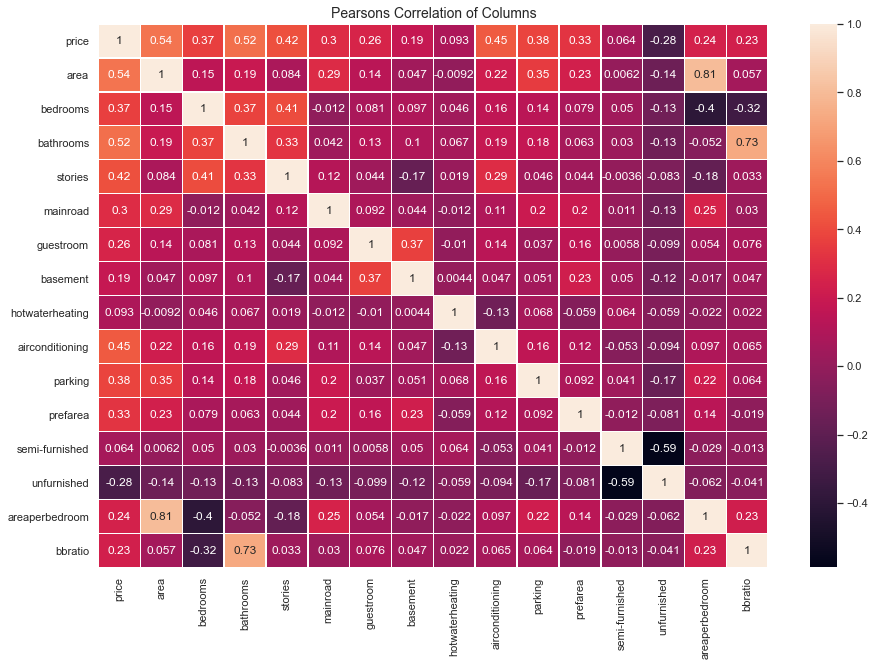

In [17]:
plt.figure(figsize = (15, 10))
sb.heatmap(df.corr(), annot = True, linewidths=0.5)
plt.title('Pearsons Correlation of Columns', fontdict={'fontsize':14})

### Feature Engineering

In [20]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,areaperbedroom,bbratio
0,5250000,5500,3,2,1,1,0,1,0,0,0,0,1,0,1833.333333,0.666667
1,4480000,4040,3,1,2,1,0,0,0,0,1,0,1,0,1346.666667,0.333333
2,3570000,3640,2,1,1,1,0,0,0,0,0,0,0,1,1820.000000,0.500000
3,2870000,3040,2,1,1,0,0,0,0,0,0,0,0,1,1520.000000,0.500000
4,3570000,4500,2,1,1,0,0,0,0,0,0,0,0,0,2250.000000,0.500000


In [21]:
x = df.drop(columns = ['price'])
y = df['price']

In [55]:
x_train, y_train, x_test, y_test = train_test_split(x, y, test_size = 0.2, random_state=40)
print('x train', x_train.shape)
print('x test', x_test.shape)
print('y train', y_train.shape)
print('y test', y_test.shape)

x train (436, 15)
x test (436,)
y train (109, 15)
y test (109,)


#### Build and evaluate instance of a model

In [59]:
def model_instance(model):
    model.fit(x_train, y_train)
    
    pred = model.predict(x_test)
    
    # confusion_matrix(model, x_test, y_test, cmap='blues')
    # plt.title('Confusion Matrix for ', model)
    # plt.show()
    
    print('Metric Evaluation of ' + str(model))
    print(f'R^2 Score : {r2_score(y_test, pred)}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test, pred))}')
    print(f'MAE : {mean_absolute_error(y_test, pred)}')
    print()

In [60]:
dtr = DecisionTreeRegressor()
svr_model = SVR()
rfr = RandomForestRegressor()
lr = LinearRegression()

models = {
    dtr : DecisionTreeRegressor(),
    svr_model : SVR(),
    rfr : RandomForestRegressor(),
    lr : LinearRegression(),
}

for i in models.keys():
    model_instance(i)

ValueError: Number of labels=109 does not match number of samples=436

In [46]:
dtr.fit(x_train, y_train)
pred = dtr.predict(x_train)

ValueError: Number of labels=109 does not match number of samples=436